features.shape: (203770, 184)
labels.shape: (203770, 2)
ラベル別件数:
 class
2    42019
1     4545
Name: count, dtype: int64
サンプル数: 46564 特徴次元: 183


C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== Full Model 評価 ===
[[ 779  130]
 [  34 8370]]
              precision    recall  f1-score   support

           0       0.96      0.86      0.90       909
           1       0.98      1.00      0.99      8404

    accuracy                           0.98      9313
   macro avg       0.97      0.93      0.95      9313
weighted avg       0.98      0.98      0.98      9313


=== TOP 20 FEATURES ===
f2: 0.050000
f53: 0.045000
f46: 0.040000
f127: 0.030000
f3: 0.030000
f89: 0.030000
f136: 0.025000
f137: 0.025000
f121: 0.020000
f125: 0.020000
f100: 0.020000
f47: 0.020000
f16: 0.020000
f40: 0.020000
f79: 0.020000
f76: 0.020000
f90: 0.015000
f102: 0.015000
f170: 0.015000
f154: 0.015000


C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== Top-20 Features Model 評価 ===
[[ 728  181]
 [  31 8373]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       909
           1       0.98      1.00      0.99      8404

    accuracy                           0.98      9313
   macro avg       0.97      0.90      0.93      9313
weighted avg       0.98      0.98      0.98      9313



  0%|          | 0/30 [00:00<?, ?it/s]


SHAP values shape: (30, 20)


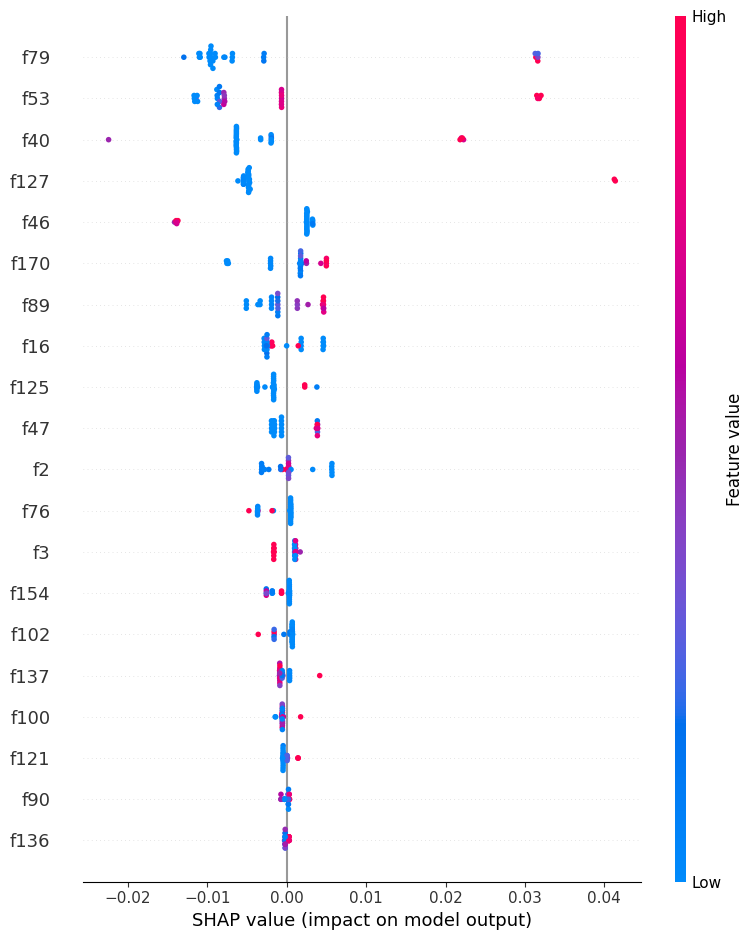

In [4]:
# ===========================================
#  Elliptic txt版 + AdaBoost（sklearn 最新版）
#  + 欠損値補完
#  + feature_importances_ 上位20特徴抽出
#  + SHAP（軽量 KernelExplainer）
# ===========================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

import shap
import matplotlib.pyplot as plt


# -------------------------------
# 1. テキスト読み込み（区切り自動判定）
# -------------------------------
features = pd.read_csv("txs_features.txt", header=None, sep=None, engine="python")
labels   = pd.read_csv("txs_classes.txt",   header=None, sep=None, engine="python")

print("features.shape:", features.shape)
print("labels.shape:", labels.shape)


# -------------------------------
# 2. 列名つける
# -------------------------------
n_feat_cols = features.shape[1]
features.columns = ["txId"] + [f"f{i}" for i in range(n_feat_cols - 1)]

labels = labels.iloc[:, :2]
labels.columns = ["txId", "class"]
labels["class"] = labels["class"].astype(str)


# -------------------------------
# 3. 結合 & 1,2 のみ使用
# -------------------------------
df = pd.merge(features, labels, on="txId")
df_bin = df[df["class"].isin(["1", "2"])].copy()

feature_cols = [c for c in df_bin.columns if c.startswith("f")]
X_full = df_bin[feature_cols].values
y = df_bin["class"].map({"1": 0, "2": 1}).values

print("ラベル別件数:\n", df_bin["class"].value_counts())
print("サンプル数:", X_full.shape[0], "特徴次元:", X_full.shape[1])


# -------------------------------
# 4. Train/Test 分割
# -------------------------------
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)


# -------------------------------
# 5. 欠損値補完（中央値）
# -------------------------------
imputer = SimpleImputer(strategy="median")
X_train_full = imputer.fit_transform(X_train_full)
X_test_full  = imputer.transform(X_test_full)


# -------------------------------
# 6. AdaBoost（最新版 param: estimator=）
# -------------------------------
base = DecisionTreeClassifier(max_depth=1)

model_full = AdaBoostClassifier(
    estimator=base,
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

model_full.fit(X_train_full, y_train)


# -------------------------------
# 7. Full model 評価
# -------------------------------
y_pred_full = model_full.predict(X_test_full)

print("\n=== Full Model 評価 ===")
print(confusion_matrix(y_test, y_pred_full))
print(classification_report(y_test, y_pred_full))


# -------------------------------
# 8. 上位20特徴抽出
# -------------------------------
importances = model_full.feature_importances_
idx_sorted = np.argsort(importances)[::-1]
idx_top = idx_sorted[:20]

top_feature_names = [feature_cols[i] for i in idx_top]

print("\n=== TOP 20 FEATURES ===")
for i in idx_top:
    print(f"{feature_cols[i]}: {importances[i]:.6f}")

X_train_top = X_train_full[:, idx_top]
X_test_top  = X_test_full[:, idx_top]


# -------------------------------
# 9. Top-20 モデル再学習
# -------------------------------
base_top = DecisionTreeClassifier(max_depth=1)

model_top = AdaBoostClassifier(
    estimator=base_top,
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)
model_top.fit(X_train_top, y_train)

y_pred_top = model_top.predict(X_test_top)

print("\n=== Top-20 Features Model 評価 ===")
print(confusion_matrix(y_test, y_pred_top))
print(classification_report(y_test, y_pred_top))


# -------------------------------
# 10. SHAP（KernelExplainer：軽量設定）
# -------------------------------

def predict_proba_class1(data):
    return model_top.predict_proba(data)[:, 1]

# 背景（ごく少数）
bg_n = min(30, X_train_top.shape[0])
bg_idx = np.random.choice(X_train_top.shape[0], bg_n, replace=False)
background = X_train_top[bg_idx]

# 説明対象（ごく少数）
ex_n = min(30, X_test_top.shape[0])
ex_idx = np.random.choice(X_test_top.shape[0], ex_n, replace=False)
X_shap = X_test_top[ex_idx]

explainer = shap.KernelExplainer(predict_proba_class1, background)
shap_values = explainer.shap_values(X_shap, nsamples=50)

shap_values = np.array(shap_values)

print("\nSHAP values shape:", shap_values.shape)


# -------------------------------
# 11. summary_plot
# -------------------------------
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=top_feature_names,
    show=True
)
